#RGDAT (RoBERTa based Graphical Dual Attention Network with Power Dynamics)

###SENDER LABELS

###Importing the libraries

In [ ]:
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score
import json
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from torch_geometric.nn import GATConv

###Adding random seed

In [ ]:
SEED = 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

###Label Smoothing Loss

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, targets):
        logprobs = F.log_softmax(logits, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

###Graph pooling


In [ ]:
class GraphPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, node_feats):
        weights = torch.softmax(self.attn(node_feats), dim=0)
        return torch.sum(weights * node_feats, dim=0)

###Graph Encoder

In [ ]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, heads=4):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.2)
        self.res_fc = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

    def forward(self, x, edge_index):
        x_res = self.res_fc(x)
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index) + x_res)
        return x

###Power Features

In [ ]:
class PowerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return F.leaky_relu(self.fc(x), negative_slope=0.2)


###Dual Attention

In [ ]:
class DualAttention(nn.Module):
    def __init__(self, hidden_dim, heads=4):
        super().__init__()
        self.heads = heads
        self.query = nn.Linear(hidden_dim, hidden_dim * heads)
        self.key = nn.Linear(hidden_dim, hidden_dim * heads)
        self.value = nn.Linear(hidden_dim, hidden_dim * heads)
        self.out_proj = nn.Linear(hidden_dim * heads, hidden_dim)

    def forward(self, text_emb, graph_emb):
        combined = torch.stack([text_emb, graph_emb], dim=1)
        q = self.query(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)
        k = self.key(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)
        v = self.value(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).reshape(q.size(0), 2, -1).mean(dim=1)
        return self.out_proj(context)


###Deception Detector

In [ ]:
class DeceptionDetector(nn.Module):
    def __init__(self, roberta_model_name='roberta-base', power_dim=10, graph_feat_dim=128, hidden_dim=256):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        roberta_dim = self.roberta.config.hidden_size
        self.roberta_proj = nn.Linear(roberta_dim, hidden_dim) if roberta_dim != hidden_dim else nn.Identity()

        self.power_encoder = PowerEncoder(power_dim, hidden_dim)
        self.graph_encoder = GraphEncoder(graph_feat_dim, hidden_dim)
        self.graph_pool = GraphPooling(hidden_dim)
        self.dual_attn = DualAttention(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, input_ids, attention_mask, power_feats, graph_feats, edge_indices):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_cls = self.roberta_proj(roberta_output.last_hidden_state[:, 0, :])
        power_encoded = self.power_encoder(power_feats)
        text_feat = self.dropout(roberta_cls + power_encoded)

        all_graph_feats = torch.cat(graph_feats, dim=0)
        edge_indices = [edge_index + i * graph_feats[i].size(0) for i, edge_index in enumerate(edge_indices)]
        batched_edge_index = torch.cat(edge_indices, dim=1)
        graph_feat = self.graph_encoder(all_graph_feats, batched_edge_index)

        split_sizes = [gf.size(0) for gf in graph_feats]
        graph_feat = torch.split(graph_feat, split_sizes)
        graph_feat = torch.stack([self.graph_pool(g) for g in graph_feat])
        graph_feat = self.dropout(graph_feat)

        final_feat = self.dual_attn(text_feat, graph_feat)
        return self.classifier(final_feat)

###Deception Dataset

In [ ]:
class DiplomacyDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_len=128):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_len = max_len

        for line in open(jsonl_path):
            game_data = json.loads(line)
            self.process_game(game_data)

    def process_game(self, game_data):
        game_state = {
            'power_scores': {},
            'message_counts': {},
            'recent_deceptions': {},
            'relationships': set()
        }

        players = list(set(game_data['speakers'] + [r for r in game_data['receivers'] if r != "NOANNOTATION"]))
        for player in players:
            game_state['power_scores'][player] = 0
            game_state['message_counts'][player] = 0
            game_state['recent_deceptions'][player] = []

        G = nx.Graph()
        for sender, receiver in zip(game_data['speakers'], game_data['receivers']):
            if receiver != "NOANNOTATION":
                G.add_edge(sender, receiver)
        centrality = nx.betweenness_centrality(G)

        for i, (msg, sender, receiver, r_label) in enumerate(zip(
            game_data['messages'], game_data['speakers'], game_data['receivers'], game_data['sender_labels']
        )):
            if receiver == "NOANNOTATION":
                continue

            game_state['message_counts'][sender] += 1
            game_state['power_scores'][sender] = float(game_data['game_score'][i])

            if not r_label:
                game_state['recent_deceptions'][sender].append(1)
                if len(game_state['recent_deceptions'][sender]) > 5:
                    game_state['recent_deceptions'][sender].pop(0)

            game_state['relationships'].add((sender, receiver))
            game_state['relationships'].add((receiver, sender))

            power_feats = self.get_power_features(game_data, i, game_state)
            graph_feats = self.get_graph_features(players, game_state, centrality)
            edge_index = self.get_edge_index(players, game_state)

            self.samples.append({
                'text': msg,
                'label': 1 if r_label else 0,
                'power_feats': power_feats,
                'graph_feats': graph_feats,
                'edge_index': edge_index
            })

    def get_power_features(self, game_data, msg_idx, game_state):
        sender = game_data['speakers'][msg_idx]
        receiver = game_data['receivers'][msg_idx]

        decayed_deception = sum([d * (0.9 ** t) for t, d in enumerate(reversed(game_state['recent_deceptions'][sender]))])

        features = [
            float(game_data['game_score_delta'][msg_idx]),
            game_state['power_scores'][sender] - game_state['power_scores'].get(receiver, 0),
            int(game_data['years'][msg_idx]) - 1901,
            1 if game_data['seasons'][msg_idx] == 'Spring' else 0,
            1 if game_data['seasons'][msg_idx] == 'Fall' else 0,
            game_state['message_counts'][sender] / (sum(game_state['message_counts'].values()) + 1e-6),
            decayed_deception,
            msg_idx / len(game_data['messages']),
            game_data['relative_message_index'][msg_idx] / 100,
            len([d for d in game_state['recent_deceptions'][sender] if d == 1]) / 5.0
        ]
        return features[:10]

    def get_graph_features(self, players, game_state, centrality):
        player_features = []
        for player in players:
            features = [
                game_state['power_scores'][player],
                game_state['message_counts'][player],
                sum(game_state['recent_deceptions'][player]) / 5.0,
                centrality.get(player, 0),
                sum(1 for p in players if (player, p) in game_state['relationships'])
            ]
            features = torch.tensor(features, dtype=torch.float)
            features = (features - features.mean()) / (features.std() + 1e-5)
            padded = F.pad(features, (0, 128 - features.size(0)))
            player_features.append(padded.tolist())
        return player_features

    def get_edge_index(self, players, game_state):
        player_to_idx = {p: i for i, p in enumerate(players)}
        edges = [[player_to_idx[p1], player_to_idx[p2]] for (p1, p2) in game_state['relationships']]
        return torch.tensor(edges or [[0, 1], [1, 0]], dtype=torch.long).t().contiguous()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        encoded = self.tokenizer(sample['text'], padding='max_length', truncation=True,
                               max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'power_feats': torch.tensor(sample['power_feats'], dtype=torch.float),
            'graph_feats': torch.tensor(sample['graph_feats'], dtype=torch.float),
            'edge_index': sample['edge_index'],
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

###Collate function

In [ ]:
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'power_feats': torch.stack([item['power_feats'] for item in batch]),
        'graph_feats': [item['graph_feats'] for item in batch],
        'edge_index': [item['edge_index'] for item in batch],
        'label': torch.stack([item['label'] for item in batch])
    }

###Train Function

In [ ]:
def train(model, dataloader, optimizer, scheduler, criterion, device, grad_accum_steps=4):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        power_feats = batch['power_feats'].to(device)
        labels = batch['label'].to(device)
        graph_feats = [gf.to(device) for gf in batch['graph_feats']]
        edge_indices = [ei.to(device) for ei in batch['edge_index']]

        logits = model(input_ids, attention_mask, power_feats, graph_feats, edge_indices)
        loss = criterion(logits, labels) / grad_accum_steps
        loss.backward()

        if (i + 1) % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1

### Evaluate Function

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            power_feats = batch['power_feats'].to(device)
            labels = batch['label'].to(device)
            graph_feats = [gf.to(device) for gf in batch['graph_feats']]
            edge_indices = [ei.to(device) for ei in batch['edge_index']]

            logits = model(input_ids, attention_mask, power_feats, graph_feats, edge_indices)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Train Loss: 0.4765 | Val Loss: 0.4154
Train Acc: 0.8198 | Val Acc: 0.8672
Train F1: 0.8197 | Val F1: 0.5963
--------------------------------------------------
✓ Saved new best model.
Epoch 2
Train Loss: 0.3196 | Val Loss: 0.3534
Train Acc: 0.9385 | Val Acc: 0.9174
Train F1: 0.9385 | Val F1: 0.6147
--------------------------------------------------
✓ Saved new best model.
Epoch 3
Train Loss: 0.2597 | Val Loss: 0.3317
Train Acc: 0.9759 | Val Acc: 0.9188
Train F1: 0.9758 | Val F1: 0.5874
--------------------------------------------------
Epoch 4
Train Loss: 0.2339 | Val Loss: 0.3194
Train Acc: 0.9874 | Val Acc: 0.9350
Train F1: 0.9874 | Val F1: 0.5724
--------------------------------------------------
Epoch 5
Train Loss: 0.2194 | Val Loss: 0.3047
Train Acc: 0.9909 | Val Acc: 0.9548
Train F1: 0.9909 | Val F1: 0.5313
--------------------------------------------------
Epoch 6
Train Loss: 0.2166 | Val Loss: 0.3101
Train Acc: 0.9912 | Val Acc: 0.9513
Train F1: 0.9912 | Val F1: 0.5615
-

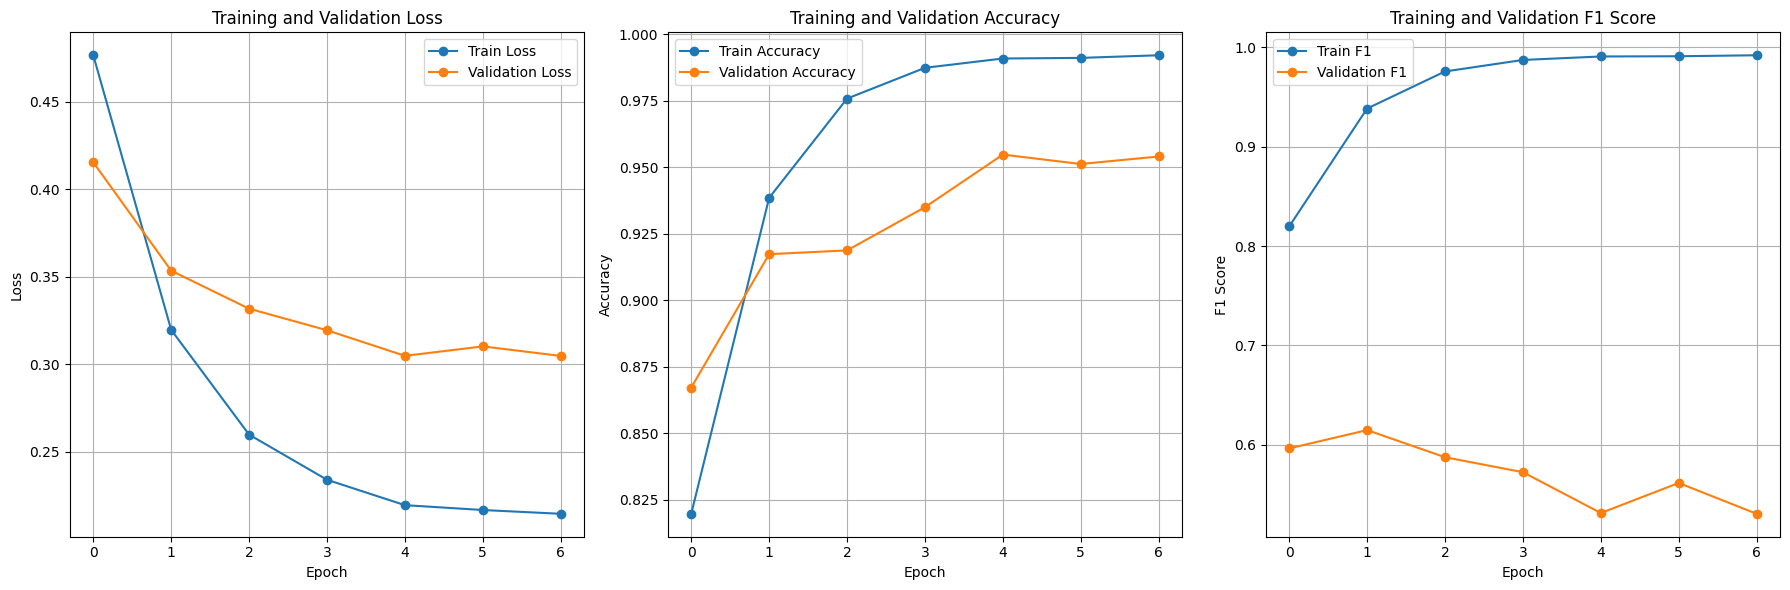

In [3]:
if __name__ == '__main__':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    train_dataset = DiplomacyDataset('train.jsonl', tokenizer)
    val_dataset = DiplomacyDataset('validation.jsonl', tokenizer)
    test_dataset = DiplomacyDataset('test.jsonl', tokenizer)

    labels = [sample['label'] for sample in train_dataset.samples]
    class_counts = np.bincount(labels)
    weights = 1. / class_counts[labels]
    sampler = WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeceptionDetector().to(device)
    optimizer = torch.optim.AdamW([
        {'params': model.roberta.parameters(), 'lr': 1e-5},
        {'params': [p for n, p in model.named_parameters() if 'roberta' not in n], 'lr': 2e-4}
    ])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_loader)*20)
    criterion = LabelSmoothingLoss(smoothing=0.1)

    best_f1 = 0.0
    patience = 5
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(20):
        train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        print("-" * 50)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_sender.pt")
            print("✓ Saved new best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_sender.pt"))
    test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Performance:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Acc: {test_acc:.4f}")
    print(f"Test F1: {test_f1:.4f}")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label='Train F1', marker='o')
    plt.plot(val_f1s, label='Validation F1', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00


##RECEIVER LABELS

###Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from torch_geometric.nn import GATConv
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score
import json
import numpy as np
import random
import matplotlib.pyplot as plt

###Reproducbility

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

###Loss Functions

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, targets):
        logprobs = F.log_softmax(logits, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

###Graph Components

In [ ]:
class GraphPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, node_feats):
        weights = torch.softmax(self.attn(node_feats), dim=0)
        return torch.sum(weights * node_feats, dim=0)

In [ ]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, heads=4):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.2)
        self.res_fc = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

    def forward(self, x, edge_index):
        x_res = self.res_fc(x)
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index) + x_res)
        return x

###Model Architecture

In [ ]:
class PowerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return F.leaky_relu(self.fc(x), negative_slope=0.2)

In [ ]:
class DualAttention(nn.Module):
    def __init__(self, hidden_dim, heads=4):
        super().__init__()
        self.heads = heads
        self.query = nn.Linear(hidden_dim, hidden_dim * heads)
        self.key = nn.Linear(hidden_dim, hidden_dim * heads)
        self.value = nn.Linear(hidden_dim, hidden_dim * heads)
        self.out_proj = nn.Linear(hidden_dim * heads, hidden_dim)

    def forward(self, text_emb, graph_emb):
        combined = torch.stack([text_emb, graph_emb], dim=1)
        q = self.query(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)
        k = self.key(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)
        v = self.value(combined).view(combined.size(0), 2, self.heads, -1).transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).reshape(q.size(0), 2, -1).mean(dim=1)
        return self.out_proj(context)

In [ ]:
class DeceptionDetector(nn.Module):
    def __init__(self, roberta_model_name='roberta-base', power_dim=10, graph_feat_dim=128, hidden_dim=256):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        roberta_dim = self.roberta.config.hidden_size
        self.roberta_proj = nn.Linear(roberta_dim, hidden_dim) if roberta_dim != hidden_dim else nn.Identity()

        self.power_encoder = PowerEncoder(power_dim, hidden_dim)
        self.graph_encoder = GraphEncoder(graph_feat_dim, hidden_dim)
        self.graph_pool = GraphPooling(hidden_dim)
        self.dual_attn = DualAttention(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, input_ids, attention_mask, power_feats, graph_feats, edge_indices):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_cls = self.roberta_proj(roberta_output.last_hidden_state[:, 0, :])
        power_encoded = self.power_encoder(power_feats)
        text_feat = self.dropout(roberta_cls + power_encoded)

        all_graph_feats = torch.cat(graph_feats, dim=0)
        edge_indices = [edge_index + i * graph_feats[i].size(0) for i, edge_index in enumerate(edge_indices)]
        batched_edge_index = torch.cat(edge_indices, dim=1)
        graph_feat = self.graph_encoder(all_graph_feats, batched_edge_index)

        split_sizes = [gf.size(0) for gf in graph_feats]
        graph_feat = torch.split(graph_feat, split_sizes)
        graph_feat = torch.stack([self.graph_pool(g) for g in graph_feat])
        graph_feat = self.dropout(graph_feat)

        final_feat = self.dual_attn(text_feat, graph_feat)
        return self.classifier(final_feat)

###Dataset

In [ ]:
class DiplomacyDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_len=128):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_len = max_len

        for line in open(jsonl_path):
            game_data = json.loads(line)
            self.process_game(game_data)

    def process_game(self, game_data):
        game_state = {
            'power_scores': {},
            'message_counts': {},
            'recent_deceptions': {},
            'relationships': set()
        }

        players = list(set(game_data['speakers'] + [r for r in game_data['receivers'] if r != "NOANNOTATION"]))
        for player in players:
            game_state['power_scores'][player] = 0
            game_state['message_counts'][player] = 0
            game_state['recent_deceptions'][player] = []

        G = nx.Graph()
        for sender, receiver in zip(game_data['speakers'], game_data['receivers']):
            if receiver != "NOANNOTATION":
                G.add_edge(sender, receiver)
        centrality = nx.betweenness_centrality(G)

        for i, (msg, sender, receiver, r_label) in enumerate(zip(
            game_data['messages'], game_data['speakers'], game_data['receivers'], game_data['receiver_labels']
        )):
            if receiver == "NOANNOTATION":
                continue

            game_state['message_counts'][sender] += 1
            game_state['power_scores'][sender] = float(game_data['game_score'][i])

            if not r_label:
                game_state['recent_deceptions'][sender].append(1)
                if len(game_state['recent_deceptions'][sender]) > 5:
                    game_state['recent_deceptions'][sender].pop(0)

            game_state['relationships'].add((sender, receiver))
            game_state['relationships'].add((receiver, sender))

            power_feats = self.get_power_features(game_data, i, game_state)
            graph_feats = self.get_graph_features(players, game_state, centrality)
            edge_index = self.get_edge_index(players, game_state)

            self.samples.append({
                'text': msg,
                'label': 1 if r_label else 0,
                'power_feats': power_feats,
                'graph_feats': graph_feats,
                'edge_index': edge_index
            })

    def get_power_features(self, game_data, msg_idx, game_state):
        sender = game_data['speakers'][msg_idx]
        receiver = game_data['receivers'][msg_idx]

        decayed_deception = sum([d * (0.9 ** t) for t, d in enumerate(reversed(game_state['recent_deceptions'][sender]))])

        features = [
            float(game_data['game_score_delta'][msg_idx]),
            game_state['power_scores'][sender] - game_state['power_scores'].get(receiver, 0),
            int(game_data['years'][msg_idx]) - 1901,
            1 if game_data['seasons'][msg_idx] == 'Spring' else 0,
            1 if game_data['seasons'][msg_idx] == 'Fall' else 0,
            game_state['message_counts'][sender] / (sum(game_state['message_counts'].values()) + 1e-6),
            decayed_deception,
            msg_idx / len(game_data['messages']),
            game_data['relative_message_index'][msg_idx] / 100,
            len([d for d in game_state['recent_deceptions'][sender] if d == 1]) / 5.0
        ]
        return features[:10]

    def get_graph_features(self, players, game_state, centrality):
        player_features = []
        for player in players:
            features = [
                game_state['power_scores'][player],
                game_state['message_counts'][player],
                sum(game_state['recent_deceptions'][player]) / 5.0,
                centrality.get(player, 0),
                sum(1 for p in players if (player, p) in game_state['relationships'])
            ]
            features = torch.tensor(features, dtype=torch.float)
            features = (features - features.mean()) / (features.std() + 1e-5)
            padded = F.pad(features, (0, 128 - features.size(0)))
            player_features.append(padded.tolist())
        return player_features

    def get_edge_index(self, players, game_state):
        player_to_idx = {p: i for i, p in enumerate(players)}
        edges = [[player_to_idx[p1], player_to_idx[p2]] for (p1, p2) in game_state['relationships']]
        return torch.tensor(edges or [[0, 1], [1, 0]], dtype=torch.long).t().contiguous()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        encoded = self.tokenizer(sample['text'], padding='max_length', truncation=True,
                               max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'power_feats': torch.tensor(sample['power_feats'], dtype=torch.float),
            'graph_feats': torch.tensor(sample['graph_feats'], dtype=torch.float),
            'edge_index': sample['edge_index'],
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

###Training Utilities

In [ ]:
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'power_feats': torch.stack([item['power_feats'] for item in batch]),
        'graph_feats': [item['graph_feats'] for item in batch],
        'edge_index': [item['edge_index'] for item in batch],
        'label': torch.stack([item['label'] for item in batch])
    }

###Train function

In [ ]:
def train(model, dataloader, optimizer, scheduler, criterion, device, grad_accum_steps=4):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        power_feats = batch['power_feats'].to(device)
        labels = batch['label'].to(device)
        graph_feats = [gf.to(device) for gf in batch['graph_feats']]
        edge_indices = [ei.to(device) for ei in batch['edge_index']]

        logits = model(input_ids, attention_mask, power_feats, graph_feats, edge_indices)
        loss = criterion(logits, labels) / grad_accum_steps
        loss.backward()

        if (i + 1) % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1

###Evaluate function

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            power_feats = batch['power_feats'].to(device)
            labels = batch['label'].to(device)
            graph_feats = [gf.to(device) for gf in batch['graph_feats']]
            edge_indices = [ei.to(device) for ei in batch['edge_index']]

            logits = model(input_ids, attention_mask, power_feats, graph_feats, edge_indices)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Train Loss: 0.5153 | Val Loss: 0.4031
Train Acc: 0.7837 | Val Acc: 0.8658
Train F1: 0.7835 | Val F1: 0.5977
--------------------------------------------------
✓ Saved new best model.
Epoch 2
Train Loss: 0.3598 | Val Loss: 0.3261
Train Acc: 0.9120 | Val Acc: 0.9350
Train F1: 0.9120 | Val F1: 0.6590
--------------------------------------------------
✓ Saved new best model.
Epoch 3
Train Loss: 0.2668 | Val Loss: 0.3157
Train Acc: 0.9701 | Val Acc: 0.9329
Train F1: 0.9701 | Val F1: 0.6025
--------------------------------------------------
Epoch 4
Train Loss: 0.2318 | Val Loss: 0.2866
Train Acc: 0.9846 | Val Acc: 0.9576
Train F1: 0.9846 | Val F1: 0.5606
--------------------------------------------------
Epoch 5
Train Loss: 0.2227 | Val Loss: 0.3085
Train Acc: 0.9878 | Val Acc: 0.9534
Train F1: 0.9878 | Val F1: 0.5755
--------------------------------------------------
Epoch 6
Train Loss: 0.2153 | Val Loss: 0.2954
Train Acc: 0.9919 | Val Acc: 0.9569
Train F1: 0.9919 | Val F1: 0.5823
-

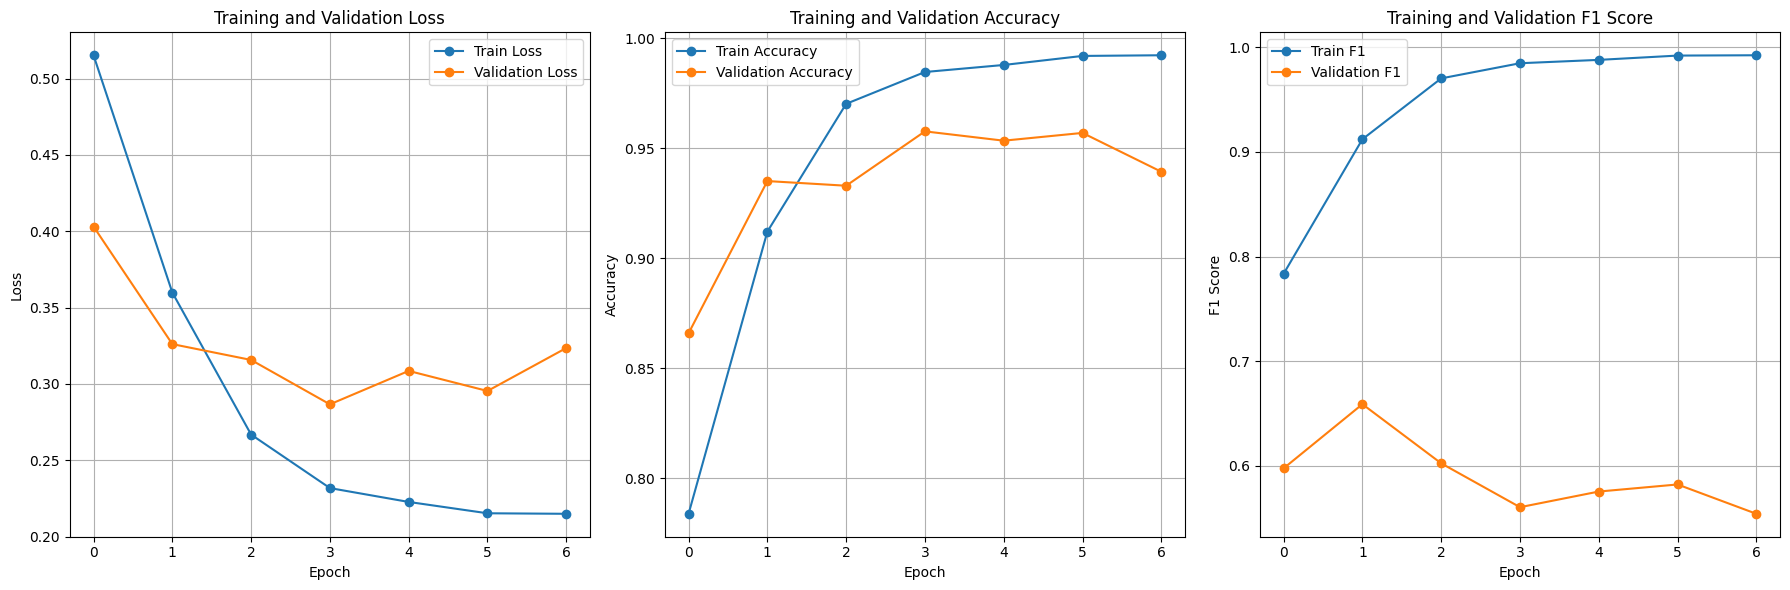

In [4]:
if __name__ == '__main__':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    train_dataset = DiplomacyDataset('train.jsonl', tokenizer)
    val_dataset = DiplomacyDataset('validation.jsonl', tokenizer)
    test_dataset = DiplomacyDataset('test.jsonl', tokenizer)

    labels = [sample['label'] for sample in train_dataset.samples]
    class_counts = np.bincount(labels)
    weights = 1. / class_counts[labels]
    sampler = WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeceptionDetector().to(device)
    optimizer = torch.optim.AdamW([
        {'params': model.roberta.parameters(), 'lr': 1e-5},
        {'params': [p for n, p in model.named_parameters() if 'roberta' not in n], 'lr': 2e-4}
    ])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_loader)*20)
    criterion = LabelSmoothingLoss(smoothing=0.1)

    best_f1 = 0.0
    patience = 5
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(20):
        train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, scheduler, criterion, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        print("-" * 50)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_receiver.pt")
            print("✓ Saved new best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_receiver.pt"))
    test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Performance:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Acc: {test_acc:.4f}")
    print(f"Test F1: {test_f1:.4f}")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label='Train F1', marker='o')
    plt.plot(val_f1s, label='Validation F1', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics_receiver.png', dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
from google.colab import files
files.download('/content/best_model_receiver.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>